In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset 
import torch.nn.functional as F
import tqdm

In [2]:
# SCALER = 'NONE'
SCALER = 'MINMAX'
# LAST_N = -15
TRAIN_TEST_SPLIT = 0.95

In [3]:
df = pd.read_csv('total.csv')
df.head()

,Date,S&P,currency,gold,kospi,kospi_shift
0,2003-12-01,1070.119995,1198.400024,402.700012,807.390015,807.780029
1,2003-12-02,1066.619995,1195.000000,403.700012,807.780029,808.340027
2,2003-12-03,1064.729980,1192.500000,403.899994,808.340027,805.130005
3,2003-12-04,1069.719971,1190.099976,403.299988,805.130005,789.409973
4,2003-12-05,1061.500000,1184.699951,406.399994,789.409973,784.799988


In [4]:
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5334,2024-05-10,5222.680176,1365.400024,2367.300049,2727.629883,2727.209961
5335,2024-05-13,5221.419922,1370.109985,2336.100098,2727.209961,2730.340088
5336,2024-05-14,5246.680176,1363.790039,2353.399902,2730.340088,2753.000000
5337,2024-05-15,5308.149902,1362.550049,2388.699951,2730.340088,2753.000000
5338,2024-05-16,5308.149902,1362.550049,2387.100098,2753.000000,2753.000000


In [5]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :]
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :]
# df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :].drop('Date', axis=1)
# df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :].drop('Date', axis=1)
# train_x, test_x, train_y, test_y = train_test_split(df_1.loc[:, 'S&P':'kospi'], df_1.loc[:, 'kospi_shift'], train_size=0.9)
col_names = df_train.columns.values
print(col_names)

['Date' 'S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [6]:
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[1:]:
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

,S&P,currency,gold,kospi,kospi_shift
mean,2.058553e+03,1120.303866,1211.516482,1907.663422,1907.894126
var,1.037695e+06,11153.970584,197132.037659,285092.585746,285066.573366
max,4.796560e+03,1571.400024,2051.500000,3305.209961,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027,719.590027


In [7]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
elif SCALER == 'NONE':
    for i in col_names[1:]:
        train_data[i] = df_train[i]
        test_data[i] = df_test[i]

test_data.tail()

,S&P,currency,gold,kospi,kospi_shift
5334,1.103426,0.699147,1.188346,0.776618,0.776456
5335,1.103121,0.706026,1.169738,0.776456,0.777667
5336,1.109252,0.696796,1.180056,0.777667,0.786430
5337,1.124171,0.694985,1.201109,0.777667,0.786430
5338,1.124171,0.694985,1.200155,0.786430,0.786430


In [8]:
len(df_test)

267

In [9]:
class StockDataset(Dataset):
    def __init__(self, y, input_window=128, output_window=1, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1
        start_pos = (L - input_window - output_window) % stride
        iter_times = (L - input_window - output_window) // stride + 1
        print(y.shape, num_samples, iter_times, start_pos, L)

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = start_pos + i * stride
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            # end_y = start_y + output_window
            # print(i, start_x, end_x)
            Y[:,i] = y[end_x: end_x + output_window]
        # print(X.shape, Y.shape)
        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        print(X.shape, Y.shape)
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [10]:
BATCH_SIZE = 64
train_dataset = StockDataset(train_data['kospi'], 128, 1, 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StockDataset(test_data['kospi'], 128, 1, 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(next(iter(test_dataset)))

(5072,) 4944 4944 0 5072
(4944, 128, 1) (4944, 1, 1)
(267,) 139 139 0 267
(139, 128, 1) (139, 1, 1)
(array([[0.6872317 ],
       [0.68510068],
       [0.67907501],
       [0.68059503],
       [0.6809392 ],
       [0.68651617],
       [0.69453745],
       [0.70319693],
       [0.71065744],
       [0.71470675],
       [0.71466804],
       [0.70973305],
       [0.71132652],
       [0.71132652],
       [0.72165672],
       [0.71840802],
       [0.71533324],
       [0.72778294],
       [0.73321677],
       [0.73321677],
       [0.73329032],
       [0.73145324],
       [0.74317569],
       [0.73860819],
       [0.74193423],
       [0.73463622],
       [0.73055981],
       [0.73723133],
       [0.73093108],
       [0.72915584],
       [0.72053894],
       [0.72482034],
       [0.71569299],
       [0.72037267],
       [0.72005937],
       [0.71340721],
       [0.70792693],
       [0.71344206],
       [0.72821219],
       [0.72466955],
       [0.71913507],
       [0.71035189],
       [0.6989116

In [11]:
print(next(iter(test_dataset))[0].shape, next(iter(test_dataset))[1].shape)

(128, 1) (1, 1)


### Make a MLP model

In [12]:
class StockMLP(nn.Module):
    def __init__(self, input_window, output_window):
        super().__init__()
        self.fc1 = nn.Linear(input_window, input_window)
        self.fc2 = nn.Linear(input_window, input_window*2)
        self.fc3 = nn.Linear(input_window*2, input_window*2)
        self.fc4 = nn.Linear(input_window*2, input_window)
        self.fc5 = nn.Linear(input_window, input_window)
        self.fc6 = nn.Linear(input_window, output_window)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = x.squeeze()
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        return x

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StockMLP(128, 1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Train

In [14]:
loss_result = pd.DataFrame(columns=['epochs', 'loss'])
epochs = 1000
for epoch in range(epochs):
    running_loss = 0.0
    for _, data in enumerate(train_dataloader):
        # print(data[0].shape)
        # print(data[1].shape)
        inputs = data[0].to(device).float()
        outputs = data[1].to(device).float()
        # model.training()
        # print(inputs)

        optimizer.zero_grad()
        result = model(inputs)
        loss = loss_fn(result, outputs.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'epoch #{epoch} loss: {running_loss:.6f}')
    loss_result.loc[epoch] = [epoch, running_loss]

epoch #0 loss: 5.619779
epoch #1 loss: 0.724068
epoch #2 loss: 0.528157
epoch #3 loss: 0.458149
epoch #4 loss: 0.373643
epoch #5 loss: 0.340736
epoch #6 loss: 0.309252
epoch #7 loss: 0.296296
epoch #8 loss: 0.280410
epoch #9 loss: 0.275055
epoch #10 loss: 0.261636
epoch #11 loss: 0.234407
epoch #12 loss: 0.239226
epoch #13 loss: 0.223401
epoch #14 loss: 0.230500
epoch #15 loss: 0.222321
epoch #16 loss: 0.220775
epoch #17 loss: 0.210399
epoch #18 loss: 0.208211
epoch #19 loss: 0.204348
epoch #20 loss: 0.196852
epoch #21 loss: 0.194828
epoch #22 loss: 0.190639
epoch #23 loss: 0.195792
epoch #24 loss: 0.186555
epoch #25 loss: 0.186250
epoch #26 loss: 0.176113
epoch #27 loss: 0.179895
epoch #28 loss: 0.178411
epoch #29 loss: 0.175597
epoch #30 loss: 0.173460
epoch #31 loss: 0.179559
epoch #32 loss: 0.166100
epoch #33 loss: 0.172768
epoch #34 loss: 0.165602
epoch #35 loss: 0.166956
epoch #36 loss: 0.163924
epoch #37 loss: 0.157841
epoch #38 loss: 0.153347
epoch #39 loss: 0.151068
epoch #40 

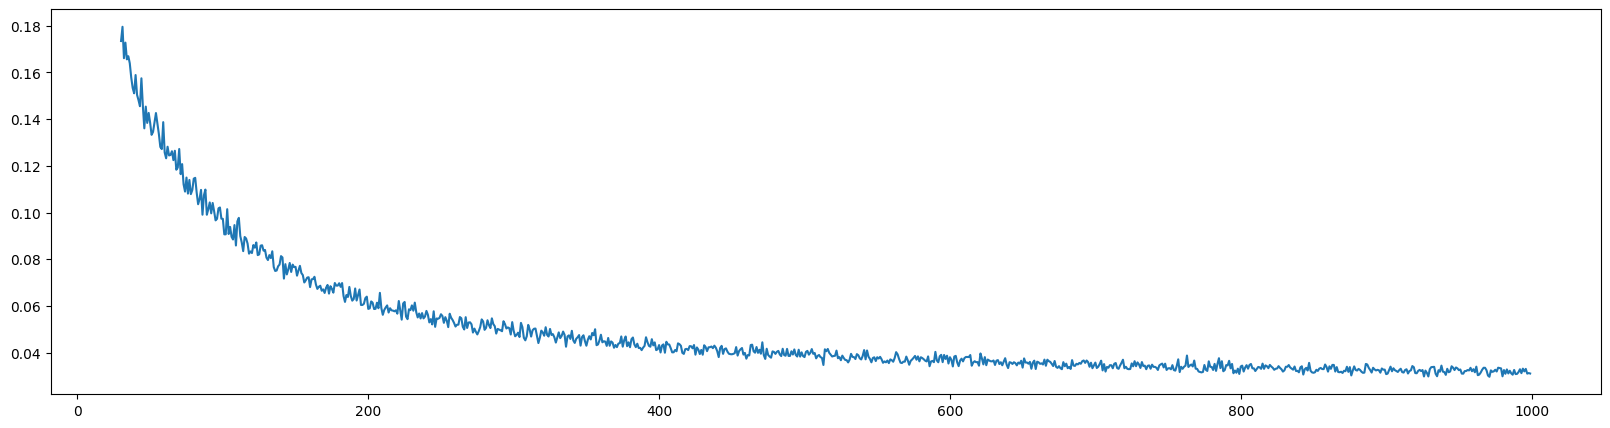

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(loss_result.loc[30: , 'epochs'], loss_result.loc[30: , 'loss'])
plt.show()

### Test

In [16]:
test_result = pd.DataFrame(columns=['pred', 'pred_rescale', 'real'])
num = 0
min = scale_params.loc['min', 'kospi']
max = scale_params.loc['max', 'kospi']
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1]

        pred = model(inputs)
        for i in range(len(pred)):
            pred_ = pred.detach().cpu().numpy()[i][0]
            pred_scaled = pred_ * (max - min) + min
            out_scaled = outputs.numpy()[i] * (max - min) + min
            test_result.loc[num] = [pred_, pred_scaled, out_scaled[0][0]]
            num += 1

In [17]:
test_result

,pred,pred_rescale,real
0,0.624815,2335.125346,2502.370117
1,0.672522,2458.477417,2443.959961
2,0.659443,2424.660126,2421.620117
3,0.668258,2447.450492,2427.080078
4,0.663599,2435.405483,2409.659912
...,...,...,...
134,0.762218,2690.394845,2727.629883
135,0.762049,2689.957929,2727.209961
136,0.732535,2613.646829,2730.340088
137,0.789586,2761.158577,2730.340088


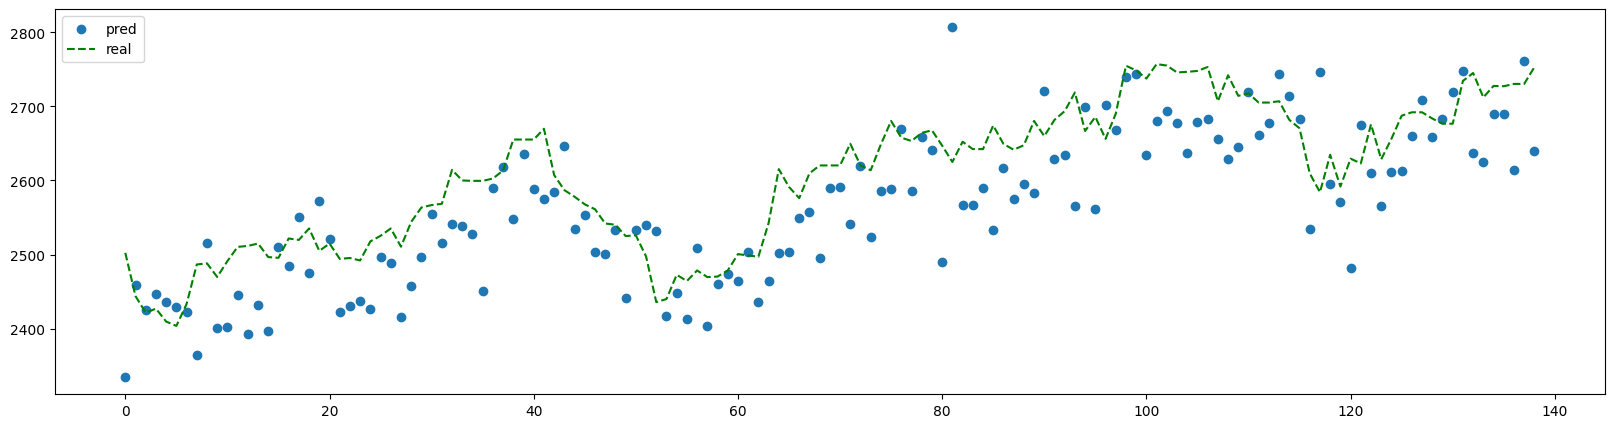

In [18]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

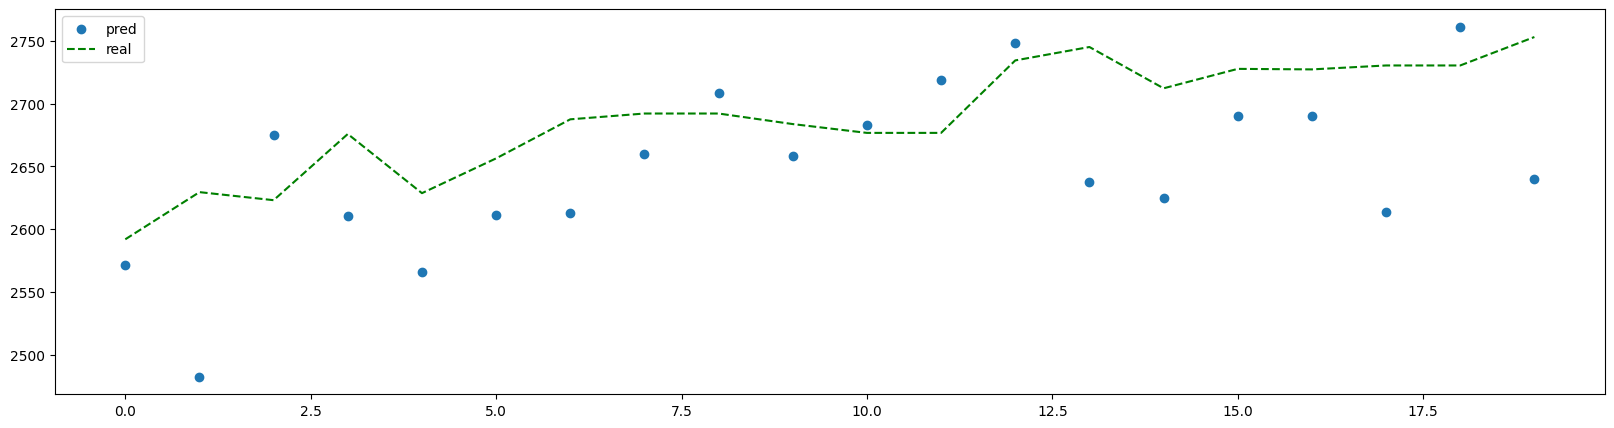

In [19]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 1], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

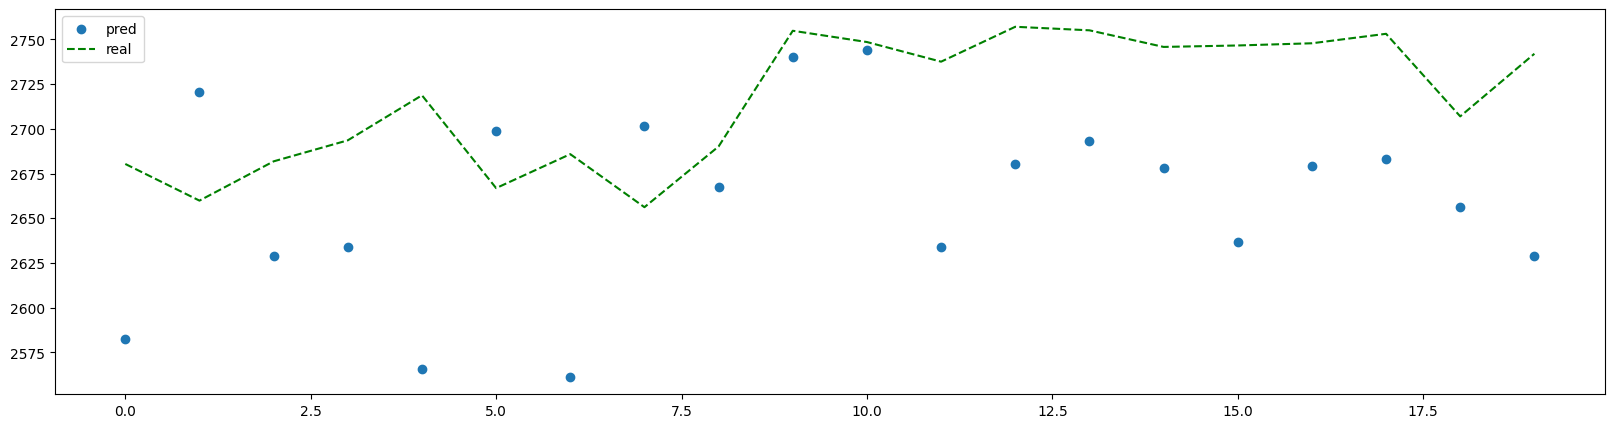

In [20]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 1], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

### moving average check - EMA(Exponential Moving Average)

In [21]:
df_ma = test_result.copy()
df_ma['sma_pred_5d'] = df_ma['pred_rescale'].rolling(5).mean()
df_ma['sma_pred_10d'] = df_ma['pred_rescale'].rolling(10).mean()
df_ma['sma_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['sma_real_5d'] = df_ma['real'].rolling(5).mean()
df_ma['sma_real_10d'] = df_ma['real'].rolling(10).mean()
df_ma['sma_real_20d'] = df_ma['real'].rolling(20).mean()
df_ma['ewm_pred_5d'] = df_ma['pred_rescale'].ewm(5).mean()
df_ma['ewm_pred_10d'] = df_ma['pred_rescale'].ewm(10).mean()
df_ma['ewm_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['ewm_real_5d'] = df_ma['real'].ewm(5).mean()
df_ma['ewm_real_10d'] = df_ma['real'].ewm(10).mean()
df_ma['ewm_real_20d'] = df_ma['real'].ewm(20).mean()
df_ma = df_ma.dropna()
df_ma

,pred,pred_rescale,real,sma_pred_5d,sma_pred_10d,sma_pred_20d,sma_real_5d,sma_real_10d,sma_real_20d,ewm_pred_5d,ewm_pred_10d,ewm_pred_20d,ewm_real_5d,ewm_real_10d,ewm_real_20d
19,0.716374,2571.860099,2505.010010,2518.497395,2466.134110,2454.666462,2515.506006,2510.243970,2479.441992,2482.439514,2464.627723,2454.666462,2505.006025,2494.975442,2487.755521
20,0.696744,2521.106037,2514.949951,2520.659751,2478.079653,2459.601727,2519.364014,2512.618970,2480.070984,2489.027128,2470.564333,2459.601727,2506.700171,2497.075024,2489.775578
21,0.658718,2422.783776,2494.280029,2508.211053,2475.790028,2456.937843,2513.868018,2511.004980,2482.586987,2477.782892,2465.612310,2456.937843,2504.591960,2496.785348,2490.101488
22,0.661583,2430.191928,2495.379883,2484.224601,2479.525390,2455.049408,2508.981982,2509.372974,2486.274976,2469.729499,2461.987458,2455.049408,2503.033082,2496.641516,2490.474177
23,0.664327,2437.287997,2492.070068,2476.645967,2480.066718,2453.823517,2500.337988,2507.083984,2489.524475,2464.253701,2459.488327,2453.823517,2501.182636,2496.178969,2490.584325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,0.762218,2690.394845,2727.629883,2683.939154,2674.219925,2646.366284,2719.161963,2702.764966,2666.580481,2665.673577,2657.805220,2646.366284,2701.005876,2690.011897,2680.605372
135,0.762049,2689.957929,2727.209961,2678.150812,2681.937864,2648.444806,2729.277979,2706.741968,2669.419482,2669.720969,2660.728201,2648.444806,2705.373223,2693.393547,2682.827556
136,0.732535,2613.646829,2730.340088,2651.211456,2677.316018,2646.785685,2728.473975,2710.569971,2675.454993,2660.375279,2656.448067,2646.785685,2709.534367,2696.752330,2685.092890
137,0.789586,2761.158577,2730.340088,2675.953380,2682.587551,2652.238507,2725.531982,2714.397974,2682.763000,2677.172495,2665.967223,2652.238507,2713.001988,2699.805769,2687.250088


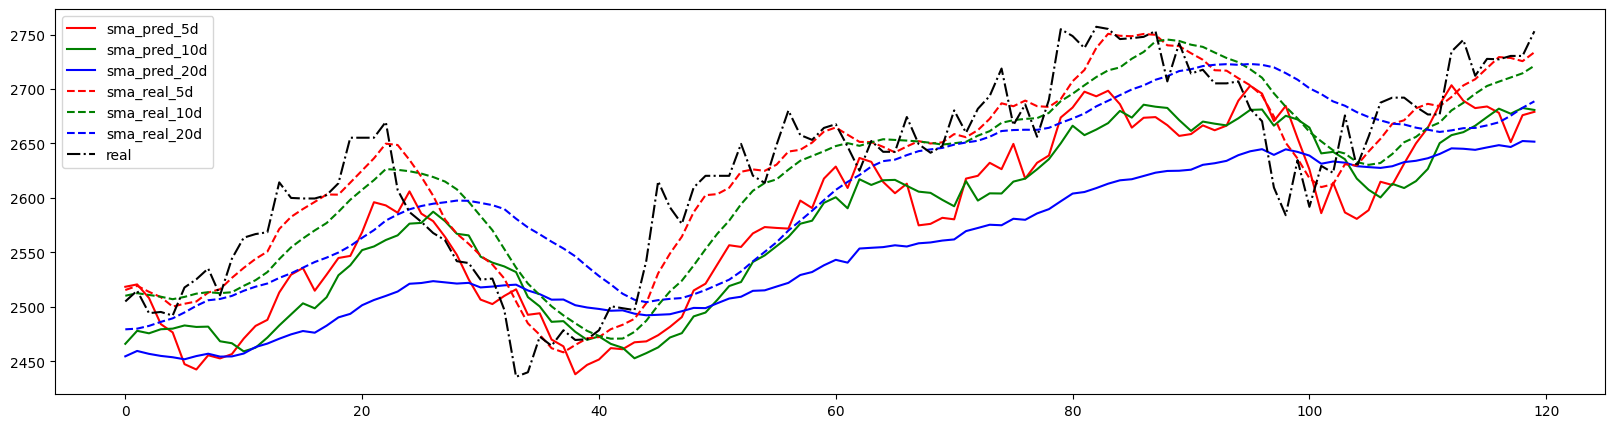

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

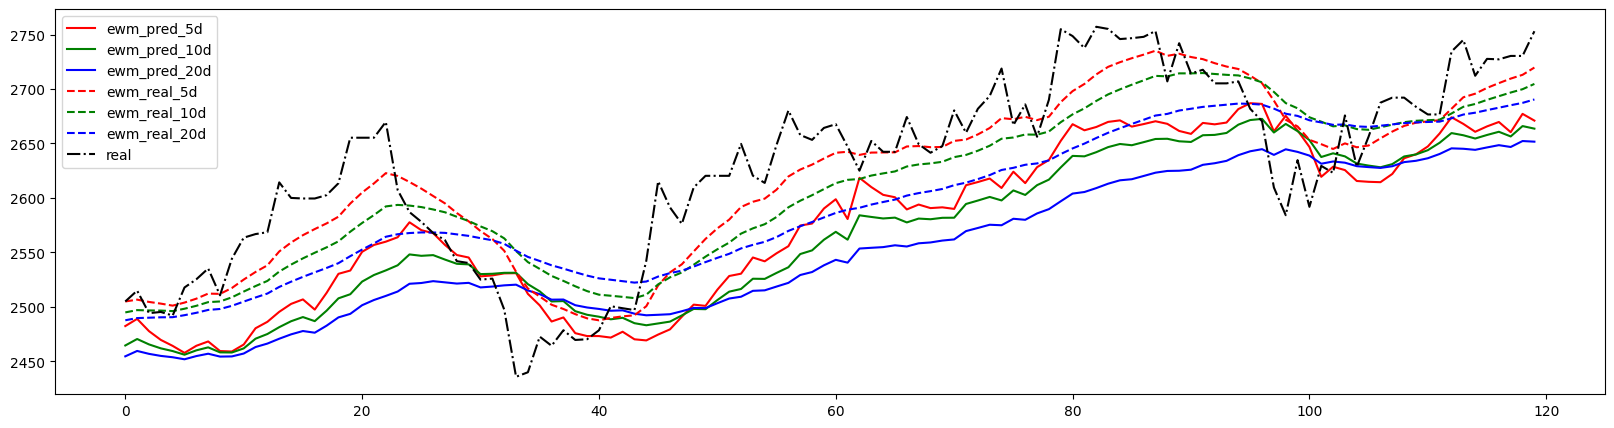

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['ewm_pred_5d'], 'r-', label='ewm_pred_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_10d'], 'g-', label='ewm_pred_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_20d'], 'b-', label='ewm_pred_20d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_5d'], 'r--', label='ewm_real_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_10d'], 'g--', label='ewm_real_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_20d'], 'b--', label='ewm_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

## evaluation metrics
MAPE, MSE

In [24]:
mse = mean_squared_error(test_result['real'], test_result['pred_rescale'])
mape = mean_absolute_percentage_error(test_result['real'], test_result['pred_rescale'])
print(f'MSE: {mse:.4f}, MAPE: {mape:.4f}')

MSE: 5079.7167, MAPE: 0.0225
